# Master Thesis: Neural Networks in Inflation Forecasting

Comparative Analysis of CNN-LSTM vs Statistical Models (ARIMA, SARIMA, VAR)

To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.
Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.


In [183]:
# R Path - required by rpy2 prior to importing libraries
import os
import os
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Resources"
os.environ["LD_LIBRARY_PATH"] = "/Library/Frameworks/R.framework/Resources/lib/"

# Basics
import numpy as np
import pandas as pd
from datetime import datetime
import joblib
import random
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data
from tensorflow.keras import layers, Model, Input

# Machine Learning - tensorflow, keras, and sklearn
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Flatten, Lambda, MaxPooling3D, Conv3D, RepeatVector, Layer

from tensorflow import keras


# SKLearn Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# Statsmodels
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import jarque_bera
import matplotlib.dates as mdates

# Univariate GARCH

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
# Suppress Keras UserWarning about input shape in RNN layers
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Suppress statsmodels ValueWarning about no frequency information
warnings.filterwarnings("ignore", category=ValueWarning, module='statsmodels')

# Suppress statsmodels ConvergenceWarning about optimization failure
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='statsmodels')

# Suppress statsmodels FutureWarning about optimization failure
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')
warnings.filterwarnings("ignore", category=FutureWarning, module='statsmodels')


# To suppress all TensorFlow warnings
# warnings.filterwarnings('ignore', category=tf.errors.UserWarning)
warnings.filterwarnings('ignore', message="6 out of the last .* calls to .* triggered tf.function retracing.*", category=UserWarning)



In [184]:

#####################################################################################################################
#                                                                                                                   #
# Data                                                                                                              #
#                                                                                                                   #
#####################################################################################################################

# Folders and worksheet names
file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)
print(f"Current working directory: {os.getcwd()}")
t_Data_Dir = 'TData/'

data = pd.read_csv(
    filepath_or_buffer = file_path + 'combined2' + '.csv',
    header=1,
    skiprows=[0]
)

data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m', errors='coerce')
df_date = data['DATE']
data.set_index('DATE', inplace=True)

data.dropna(inplace=True)



Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


# Logging, Testing Stationarity & Differencing

In [185]:
all_columns = set(data.columns)
print(all_columns)
print(len(all_columns))
df = data.copy()

{'RETAILGSR', 'CPI', 'LTIR', 'IPI', 'ECBDFR', 'MMR', 'ECBMLFR', 'STOXX50E', 'EPI', 'RETAILGF', 'RETAILMV', 'DAX', 'UR', 'WPI', 'GOODFBT', 'UNERWG', 'EW', 'RETAILXMV', 'ECBIRRO', 'PPIIP', 'HICP', 'AGRPROD'}
22


In [187]:
# Columns to be logged
non_rate_cols = ['MMR', 'CPI', 'RETAILMV', 'RETAILXMV', 'RETAILGSR', 'RETAILGF', 'GOODFBT',	'AGRPROD',	'PPIIP', 'WPI',	'EPI', 'IPI', 'STOXX50E', 'DAX', 'EW']

In [188]:
# Identify column with zero and replace with 0.0001
df_l = df.copy()
for col in non_rate_cols:
    df_l[col] = pd.to_numeric(df_l[col], errors='coerce')
    if (df[col] == 0).any():
        df_l[col] = df_l[col].replace(0, 0.001)

# Apply log transformation
for col in non_rate_cols:
    df_l[col] = np.log(df_l[col])


In [189]:
print(df_l.head(5))
print(df_l.tail(5))

            UNERWG  ECBIRRO  ECBDFR  ECBMLFR       MMR       CPI  RETAILMV  \
DATE                                                                         
1999-01-01     8.9      3.0     2.0      4.5  5.075174  4.302713  4.421247   
1999-02-01     8.8      3.0     2.0      4.5  4.867534  4.304065  4.420045   
1999-03-01     8.8      3.0     2.0      4.5  4.094345  4.304065  4.422449   
1999-04-01     8.8      2.5     1.5      3.5  6.551080  4.309456  4.424847   
1999-05-01     8.6      2.5     1.5      3.5  6.345636  4.309456  4.423648   

            RETAILXMV  RETAILGSR  RETAILGF  ...     PPIIP       WPI       EPI  \
DATE                                        ...                                 
1999-01-01   4.426044   4.335983  4.313480  ...  4.209160  4.216562  4.377014   
1999-02-01   4.424847   4.335983  4.312141  ...  4.207673  4.213608  4.377014   
1999-03-01   4.427239   4.335983  4.310799  ...  4.207673  4.219508  4.378270   
1999-04-01   4.429626   4.335983  4.312141  ... 

# Testing Stationarity & Differencing

In [190]:
def test_stationarity_adf(series, col, alpha=0.05):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f' {key}: {value}')
    is_stationary = result[1] < alpha
    print('Series:', col, is_stationary)
    return is_stationary

def test_stationarity_kpss(series, col, alpha=0.05):
    kpss_result = kpss(series, regression='ct', nlags='auto')
    print('KPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f' {key}: {value}') 
    is_stationary = kpss_result[1] >= alpha  # KPSS NULL = stationary
    print('Series:', col, is_stationary)
    return is_stationary

def test_stationarity_adf_kpss(series, name, alpha=0.05):
    # ADF Test
    adf_result = adfuller(series, autolag='AIC')
    # KPSS Test
    kpss_result = kpss(series, regression='ct', nlags='auto')

    # Interpret results
    is_stationary_adf = adf_result[1] < alpha
    is_stationary_kpss = kpss_result[1] >= alpha  # KPSS NULL = stationary

    print(f"Results for {name}:")
    print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}, Stationary: {is_stationary_adf}")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}, Stationary: {is_stationary_kpss}")
    # To avoid overdifferencing, we use ADF
    return is_stationary_kpss


In [191]:

def plot_series(series, df_date=None, title='Time Series'):
    plt.figure(figsize=(12, 6))
    if df_date is not None:
        # plt.plot(df_date, series, label='Time Series')
        plt.plot(df_date, series, label='Time Series')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format
    else:
        plt.plot(series, label='Time Series')
    plt.title(title)
    plt.xlabel('Date' if df_date is not None else 'Time')
    plt.ylabel('Value')
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.legend()
    plt.tight_layout()       # Adjust layout to prevent clipping
    plt.show()

def difference(series):
    return series.diff().dropna()

def plot_grid_series(data, column_names=None, grid_rows=4, grid_cols=3, figsize=(18, 14)):
    """
    Plots time series for multiple columns in a DataFrame in a grid layout.

    Args:
        data (pd.DataFrame): DataFrame containing time series data.
        column_names (list, optional): List of column names to plot.
                                        If None, all columns in data are plotted. Defaults to None.
        grid_rows (int, optional): Number of rows in the subplot grid. Defaults to 4.
        grid_cols (int, optional): Number of columns in the subplot grid. Defaults to 3.
        figsize (tuple, optional): Figure size for the entire grid plot. Defaults to (18, 14).
    """

    if column_names is None:
        column_names = data.columns

    num_plots = len(column_names)
    fig, axes = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=figsize)
    axes = axes.flatten() # Flatten the 2D array of axes to easily iterate

    for i, col_name in enumerate(column_names):
        series = data[col_name]
        ax = axes[i] # Get the current subplot axes

        # --- Ensure series.index is a DateTimeIndex ---
        if not isinstance(series.index, pd.DatetimeIndex):
            try:
                series.index = pd.to_datetime(series.index)
            except ValueError:
                print(f"Warning: Series index for {col_name} not in DateTime format. Plotting without date formatting.")
                ax.plot(series.values, label=col_name, color='#2b8cbe', linestyle='-', linewidth=1.5)
                ax.set_title(col_name, fontsize=14) # Smaller subplot title font
                ax.set_xlabel('Time', fontsize=10)   # Smaller subplot xlabel font
                ax.set_ylabel('Value', fontsize=10)  # Smaller subplot ylabel font
                ax.tick_params(axis='x', rotation=45, labelsize=8) # Smaller tick label font
                ax.grid(True, linestyle='--', alpha=0.5, color='gray')
                ax.legend(fontsize='small', frameon=True, edgecolor='black')
                continue # Skip date formatting for this subplot

        ax.plot(series.index, series.values, label=col_name, color='#2b8cbe', linestyle='-', linewidth=1.5)

        # --- Date Locator and Formatter for each subplot ---
        locator = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        formatter = mdates.DateFormatter('%Y-%m')
        ax.xaxis.set_major_formatter(formatter)

        ax.set_title(col_name, fontsize=14) # Smaller subplot title font
        ax.set_xlabel('Date', fontsize=10)   # Smaller subplot xlabel font
        ax.set_ylabel('Value', fontsize=10)  # Smaller subplot ylabel font

        ax.tick_params(axis='x', rotation=45, labelsize=8) # Smaller tick label font
        ax.grid(True, linestyle='--', alpha=0.5, color='gray')
        ax.legend(fontsize='small', frameon=True, edgecolor='black')

        # --- Customize Spines for each subplot ---
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)

    # Remove any unused subplots if num_plots is less than grid_rows * grid_cols
    for j in range(num_plots, grid_rows * grid_cols):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for better spacing, make room for suptitle
    plt.suptitle('Time Series Grid', fontsize=18) # Overall title for the grid
    plt.show()

def create_lag_features(df, columns, lags):
    for col in columns:
        for i in range(1, lags + 1):
            df[f'{col}_L{i}'] = df[col].shift(i)
    return df




In [241]:

# Create a summary DataFrame to store results
results = []

max_lag = 4  # you can increase this if needed
target = 'CPI'

for col in df_l.columns:
    if col == target:
        continue
    try:
        test_result = grangercausalitytests(df_l[[target, col]], maxlag=max_lag, verbose=False)
        for lag in range(1, max_lag + 1):
            p_val = test_result[lag][0]['ssr_ftest'][1]  # F-test p-value
            results.append({
                'variable': col,
                'lag': lag,
                'p_value': p_val
            })
    except Exception as e:
        print(f"Error testing {col}: {e}")

# Convert results to DataFrame
granger_df = pd.DataFrame(results)

# Show only significant results (p < 0.05)
significant = granger_df[granger_df['p_value'] < 0.05]
display(significant.sort_values(by='p_value'))


,variable,lag,p_value
53,EPI,2,1.378115e-11
83,EW,4,1.628603e-11
55,EPI,4,1.529774e-10
82,EW,3,2.858283e-10
45,PPIIP,2,3.315039e-10
54,EPI,3,3.924808e-10
47,PPIIP,4,1.216857e-09
46,PPIIP,3,9.723548e-09
49,WPI,2,2.664875e-07
57,IPI,2,3.314639e-07


In [242]:
significant_vars = sorted(significant['variable'].unique())
print(significant_vars)

['AGRPROD', 'EPI', 'EW', 'GOODFBT', 'HICP', 'IPI', 'LTIR', 'PPIIP', 'RETAILGF', 'RETAILGSR', 'RETAILMV', 'RETAILXMV', 'STOXX50E', 'WPI']


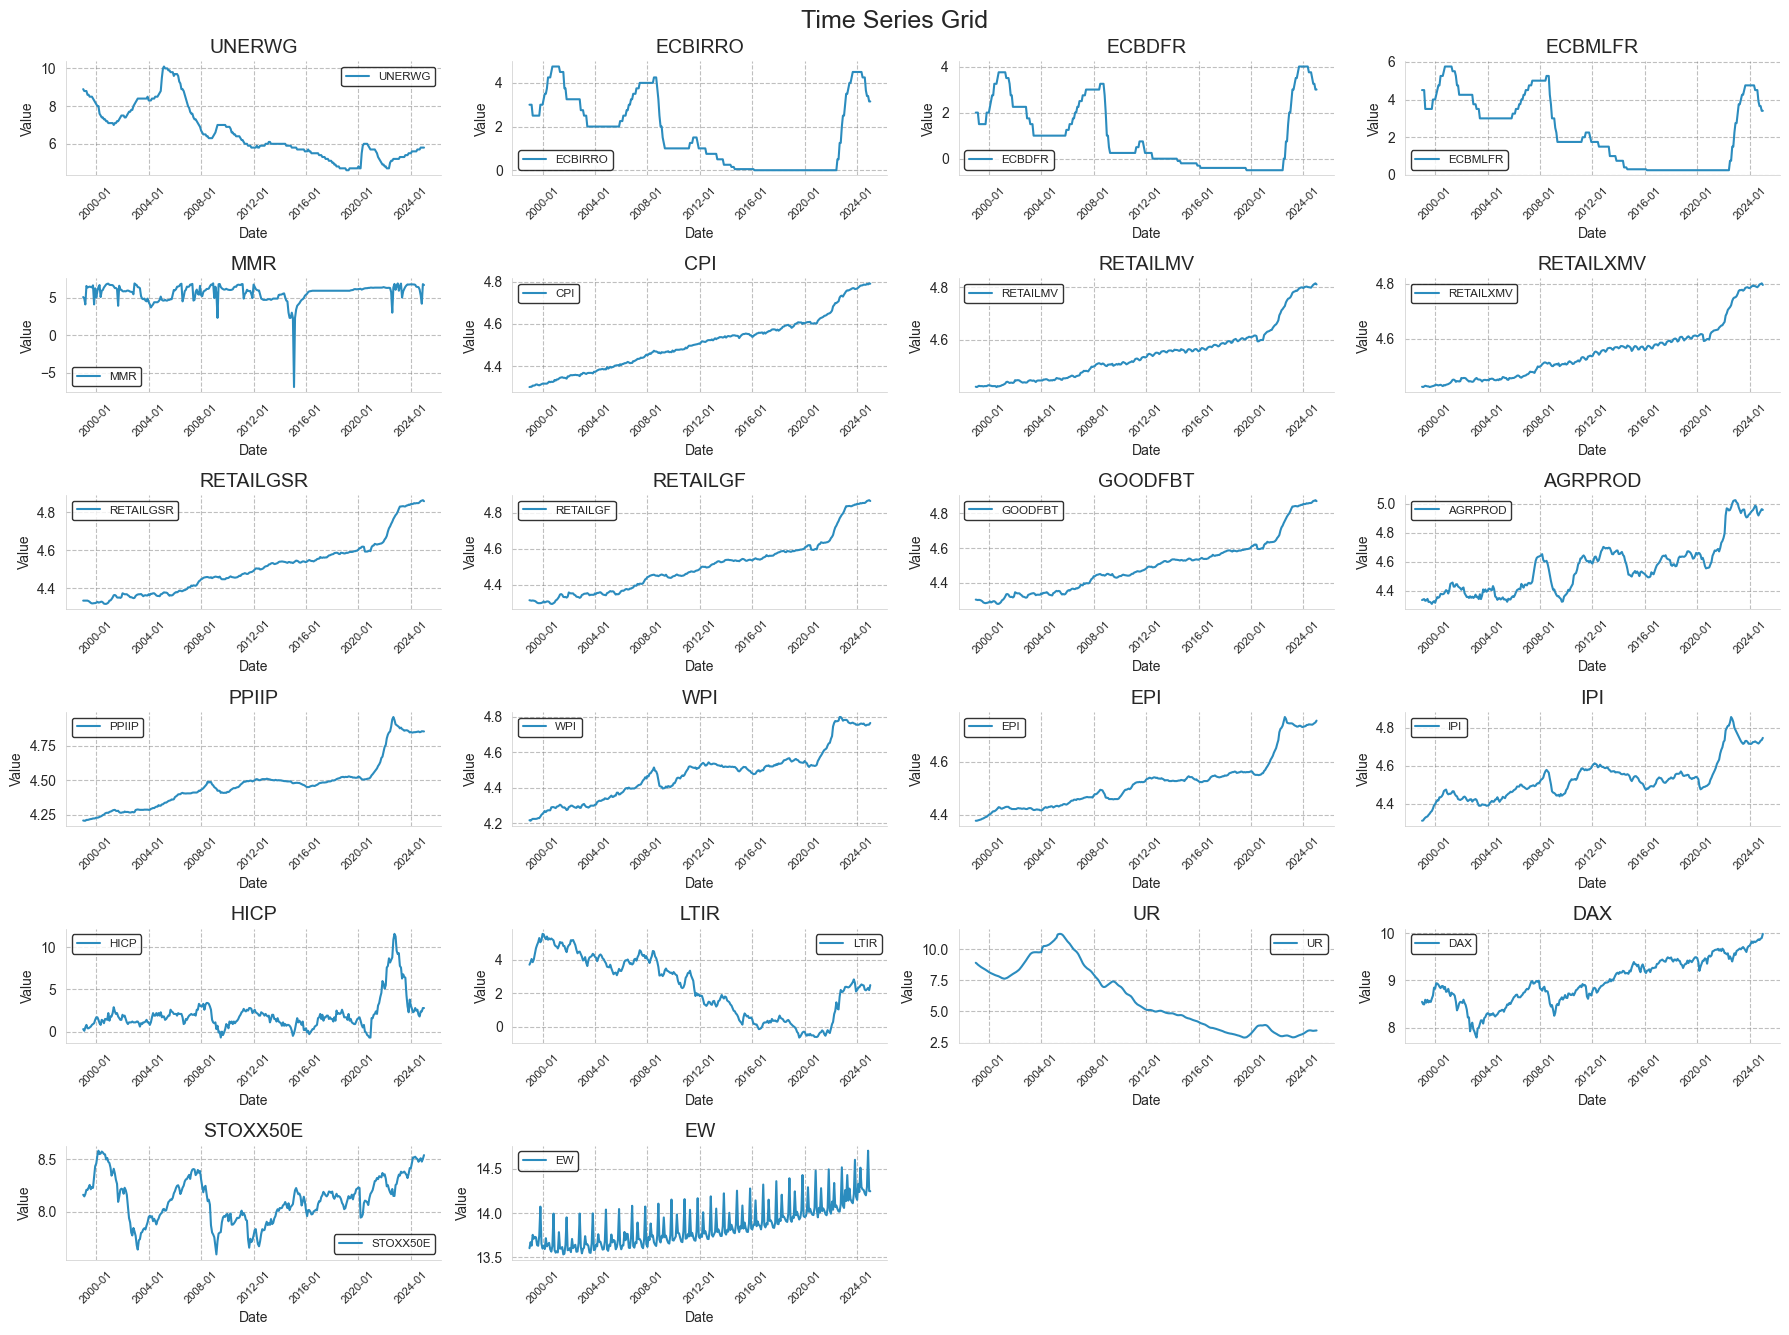

In [193]:
# --- Initial Plot ---
plot_grid_series(df_l, grid_rows=6, grid_cols=4) # Plots all columns in a nxn grid

In [194]:
non_stationary_series = []

for i in all_columns:
    series = df_l[i]
    is_stationary = test_stationarity_adf_kpss(series, i)
    if not is_stationary:
        non_stationary_series.append(i)


Results for RETAILGSR:
ADF Statistic: 0.1922, p-value: 0.9718, Stationary: False
KPSS Statistic: 0.3230, p-value: 0.0100, Stationary: False
Results for CPI:
ADF Statistic: 0.5126, p-value: 0.9853, Stationary: False
KPSS Statistic: 0.2577, p-value: 0.0100, Stationary: False
Results for LTIR:
ADF Statistic: -1.2287, p-value: 0.6611, Stationary: False
KPSS Statistic: 0.3242, p-value: 0.0100, Stationary: False
Results for IPI:
ADF Statistic: -1.7290, p-value: 0.4163, Stationary: False
KPSS Statistic: 0.1528, p-value: 0.0444, Stationary: False
Results for ECBDFR:
ADF Statistic: -2.0492, p-value: 0.2654, Stationary: False
KPSS Statistic: 0.2895, p-value: 0.0100, Stationary: False
Results for MMR:
ADF Statistic: -4.6617, p-value: 0.0001, Stationary: True
KPSS Statistic: 0.1678, p-value: 0.0318, Stationary: False
Results for ECBMLFR:
ADF Statistic: -1.9599, p-value: 0.3044, Stationary: False
KPSS Statistic: 0.3054, p-value: 0.0100, Stationary: False
Results for STOXX50E:
ADF Statistic: -2.3618

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/36554

In [220]:
print("NON Stationary Series:")
print(non_stationary_series)

NON Stationary Series:
['CPI', 'STOXX50E', 'RETAILGF', 'IPI', 'WPI', 'UNERWG', 'RETAILMV', 'HICP', 'GOODFBT', 'ECBDFR', 'ECBMLFR', 'RETAILXMV', 'UR', 'ECBIRRO', 'LTIR', 'RETAILGSR', 'PPIIP', 'AGRPROD', 'MMR', 'EPI', 'DAX']


# First Differencing

In [195]:
df_ld = df_l.copy()
second_non_stationary_series = []
for col in non_stationary_series:
    df_series = df_ld[col].diff().dropna()
    df_ld[col] = df_series
    # Check if it's now stationary
    if not test_stationarity_adf_kpss(df_series, col + " (log-diffed)"):
        second_non_stationary_series.append(col)
df_ld.dropna(inplace=True)

Results for RETAILGSR (log-diffed):
ADF Statistic: -2.9323, p-value: 0.0417, Stationary: True
KPSS Statistic: 0.0929, p-value: 0.1000, Stationary: True
Results for CPI (log-diffed):
ADF Statistic: -2.9964, p-value: 0.0352, Stationary: True
KPSS Statistic: 0.1764, p-value: 0.0249, Stationary: False
Results for LTIR (log-diffed):
ADF Statistic: -8.5226, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.1625, p-value: 0.0363, Stationary: False
Results for IPI (log-diffed):
ADF Statistic: -5.1817, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0570, p-value: 0.1000, Stationary: True
Results for ECBDFR (log-diffed):
ADF Statistic: -5.3957, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0722, p-value: 0.1000, Stationary: True
Results for MMR (log-diffed):
ADF Statistic: -14.8169, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0440, p-value: 0.1000, Stationary: True
Results for ECBMLFR (log-diffed):
ADF Statistic: -4.4964, p-value: 0.0002, Stationary: True
KPSS Statistic: 0.0

/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/36554

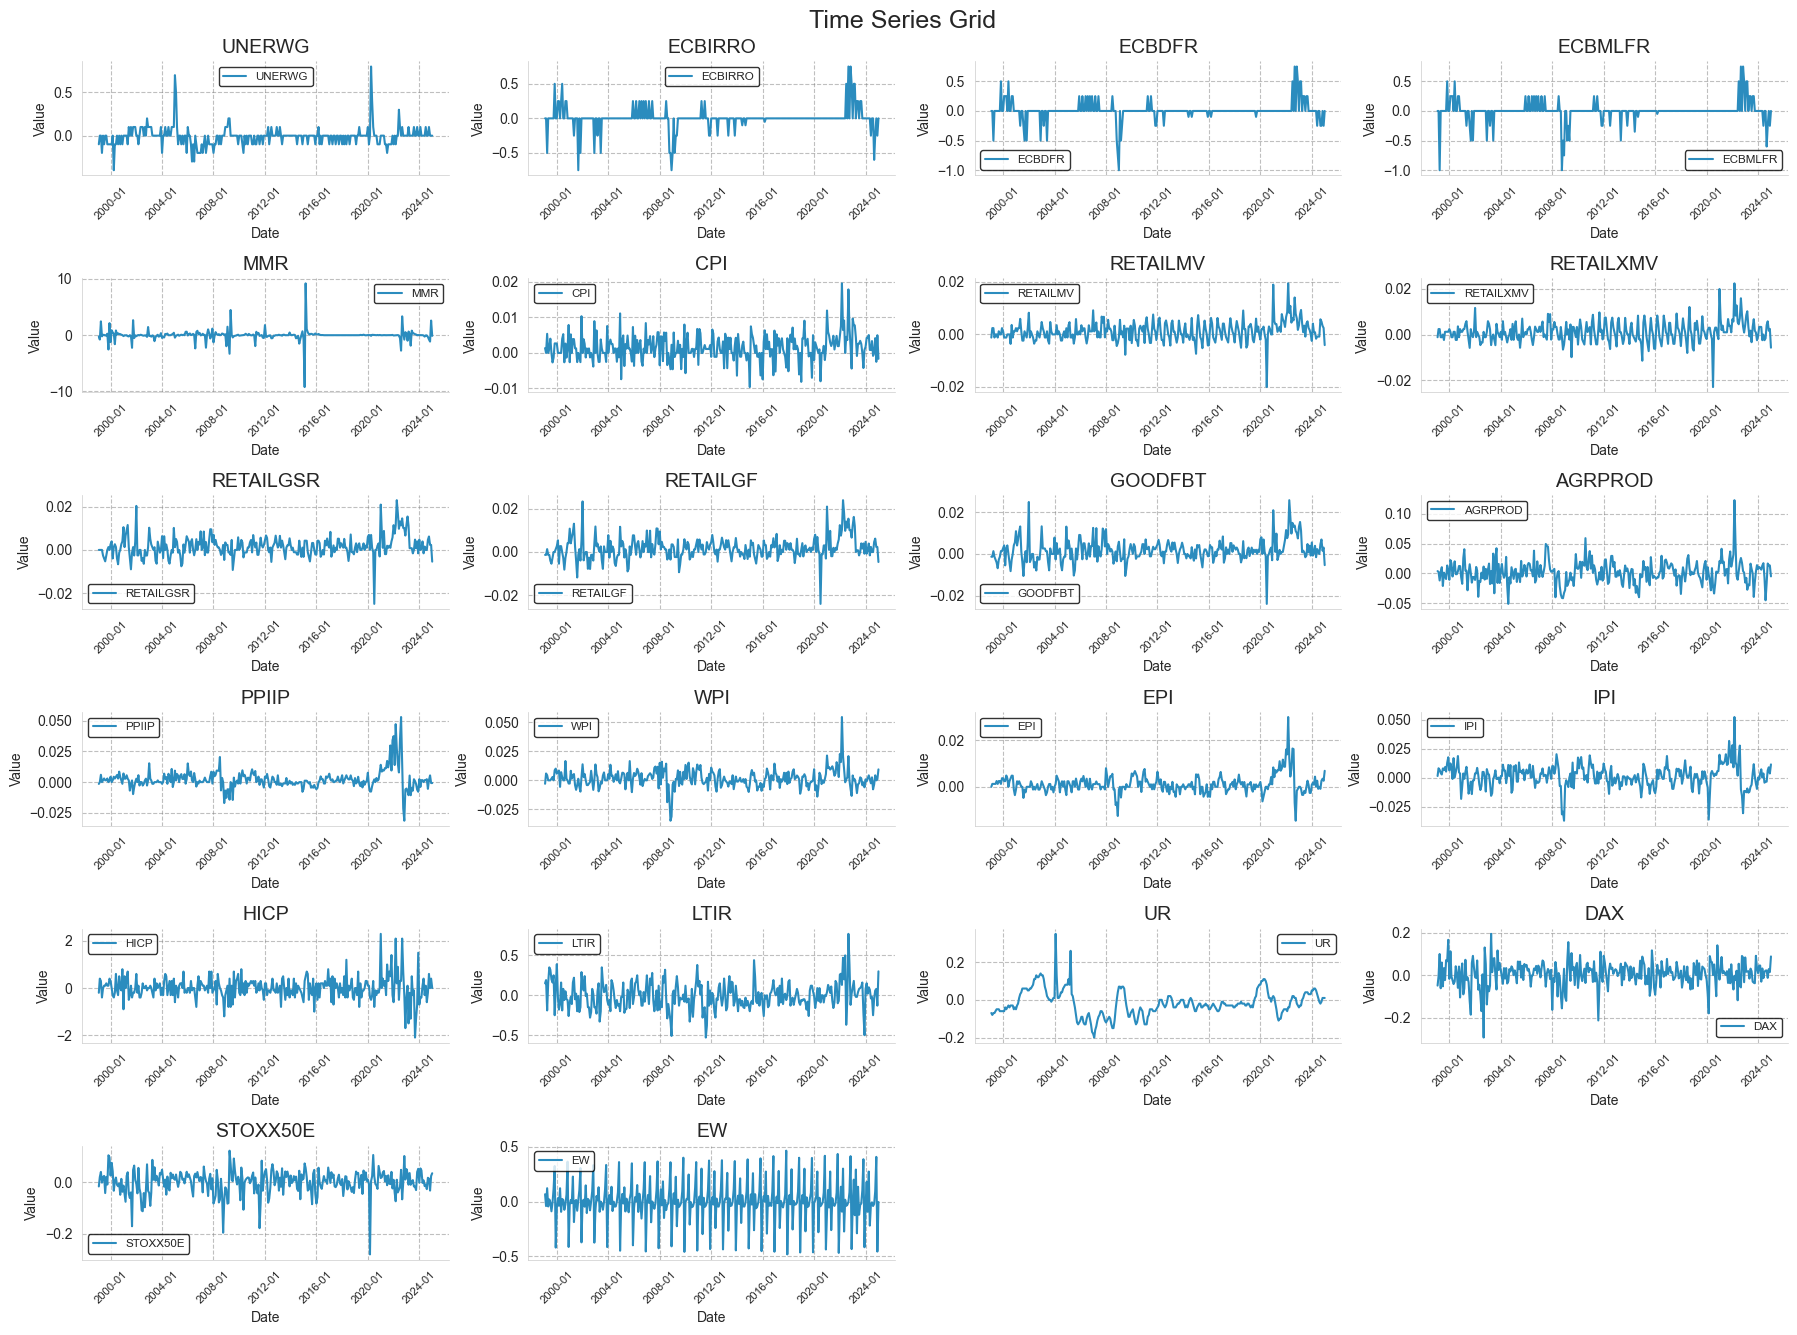

In [197]:
# --- First Plot After First Differencing ---
plot_grid_series(df_ld, grid_rows=6, grid_cols=4) # Plots all columns in a nxn grid (default)

# Second Differencing

In [198]:
print("NON Stationary Series after First Difference:")
print(second_non_stationary_series)


NON Stationary Series after First Difference:
['CPI', 'LTIR', 'RETAILMV', 'UR', 'EW']


In [199]:
third_non_stationary_series = []
df_ldd = df_ld.copy()

# for col in second_non_stationary_series:
for col in second_non_stationary_series:
    df_series = df_ldd[col].diff().dropna()
    df_ldd[col] = df_series
    # Check if it's now stationary
    if not test_stationarity_adf_kpss(df_series, col + " (log-diffed)"):
        third_non_stationary_series.append(col)

df_ldd.dropna(inplace=True)


Results for CPI (log-diffed):
ADF Statistic: -14.2493, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.1985, p-value: 0.0166, Stationary: False
Results for LTIR (log-diffed):
ADF Statistic: -9.2324, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.2441, p-value: 0.0100, Stationary: False
Results for RETAILMV (log-diffed):
ADF Statistic: -11.7136, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0783, p-value: 0.1000, Stationary: True
Results for UR (log-diffed):
ADF Statistic: -5.5993, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0241, p-value: 0.1000, Stationary: True
Results for EW (log-diffed):
ADF Statistic: -12.0404, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0219, p-value: 0.1000, Stationary: True


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/36554

In [200]:
print("NON Stationary Series after Second Difference:")
print(third_non_stationary_series)

NON Stationary Series after Second Difference:
['CPI', 'LTIR']


In [201]:
fourth_non_stationary_series = []
df_lddd = df_ldd.copy()

# for col in second_non_stationary_series:
for col in third_non_stationary_series:
    df_series = df_lddd[col].diff().dropna()
    df_lddd[col] = df_series
    # Check if it's now stationary
    if not test_stationarity_adf_kpss(df_series, col + " (log-diffed)"):
        fourth_non_stationary_series.append(col)

df_lddd.dropna(inplace=True)

Results for CPI (log-diffed):
ADF Statistic: -10.1256, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.0974, p-value: 0.1000, Stationary: True
Results for LTIR (log-diffed):
ADF Statistic: -8.8118, p-value: 0.0000, Stationary: True
KPSS Statistic: 0.1187, p-value: 0.1000, Stationary: True


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')
/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')


In [202]:
print("NON Stationary Series after Third Difference:")
print(fourth_non_stationary_series)

NON Stationary Series after Third Difference:
[]


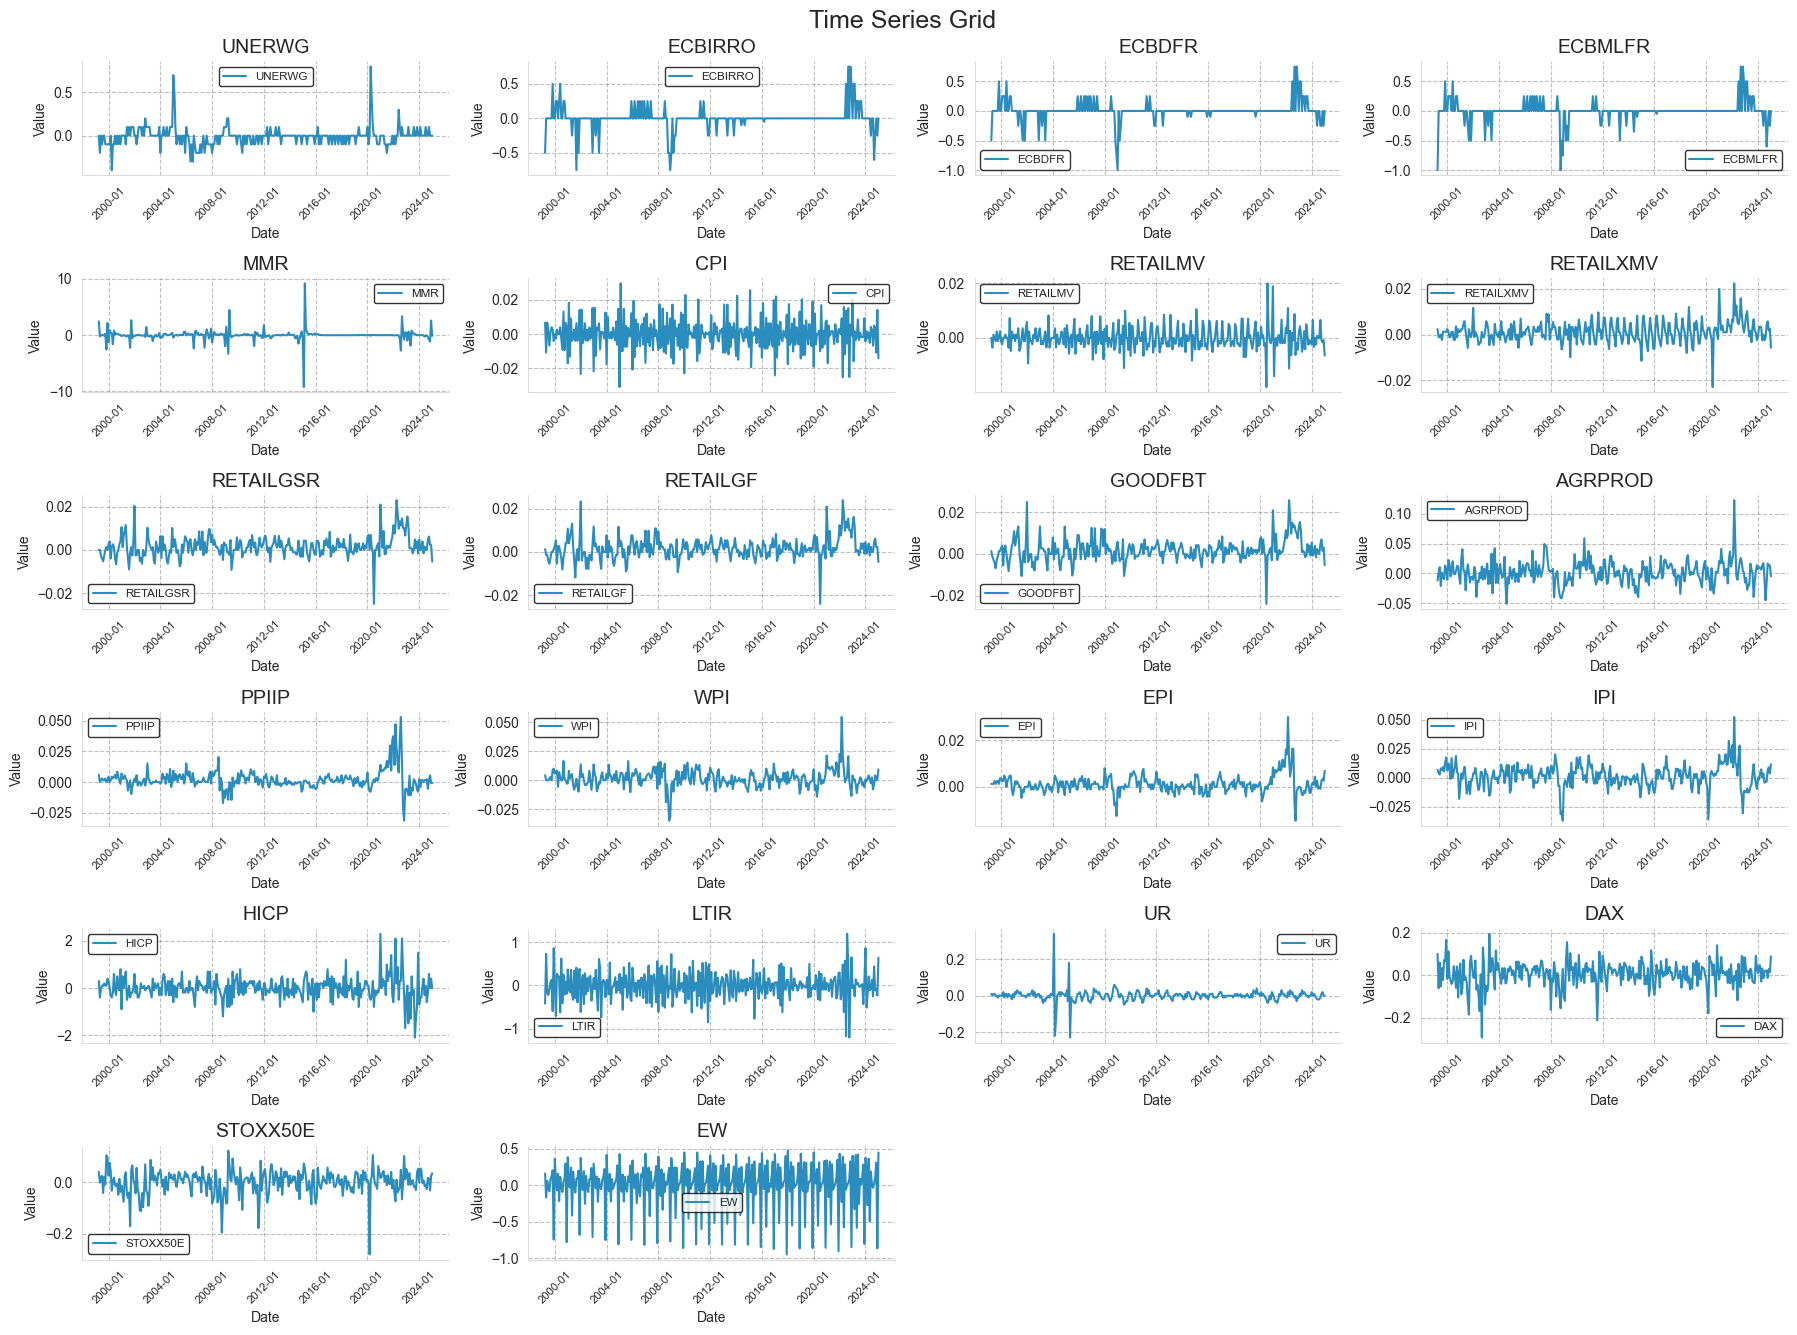

In [203]:
# --- Second Plot After Third Differencing ---
plot_grid_series(df_lddd, grid_rows=6, grid_cols=4) # Plots all columns in a nxn grid


# Descriptive Statistics of the CPI & HICP

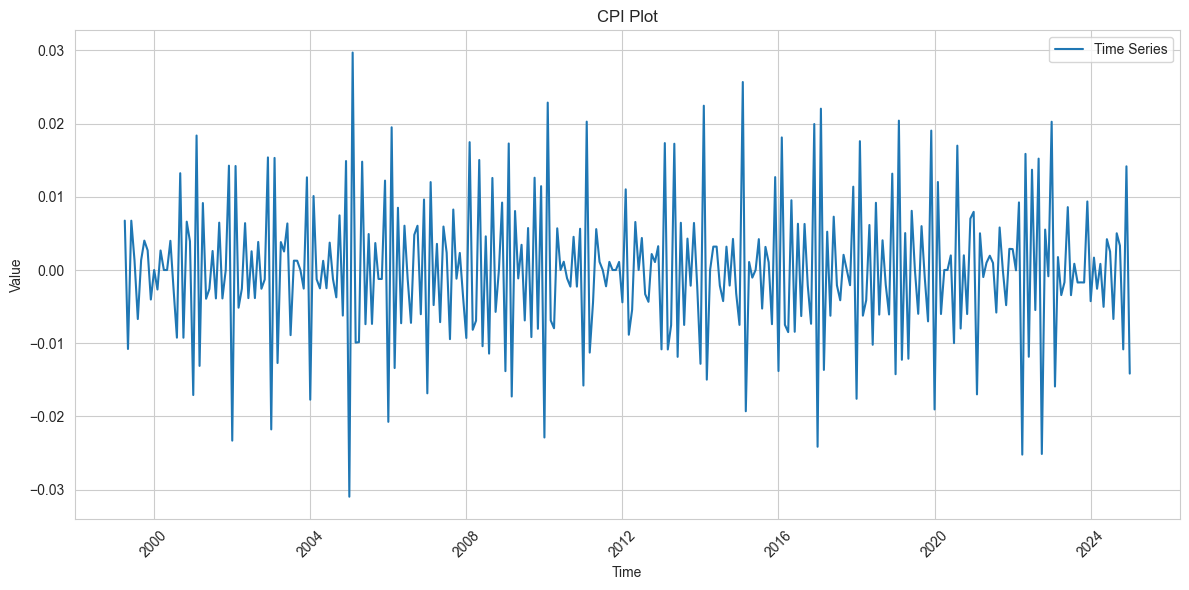

KPSS Statistic: 0.09737089307576781
p-value: 0.1
Critical Values:
 10%: 0.119
 5%: 0.146
 2.5%: 0.176
 1%: 0.216
Series: CPI True
Stationary?
True


/var/folders/82/hxq3jkp51d38wnvh074k_2vh0000gn/T/ipykernel_92435/3655496348.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')


In [204]:
cpi_series = df_lddd['CPI']
plot_series(cpi_series, title="CPI Plot")
result = test_stationarity_kpss(cpi_series, "CPI")
print("Stationary?")
print(result)

# hicp_series = df_lddd['HICP']
# plot_series(hicp_series, title="HICP Plot")
# result2 = test_stationarity_kpss(hicp_series, "HICP")
# print("Stationary?")
# print(result2)


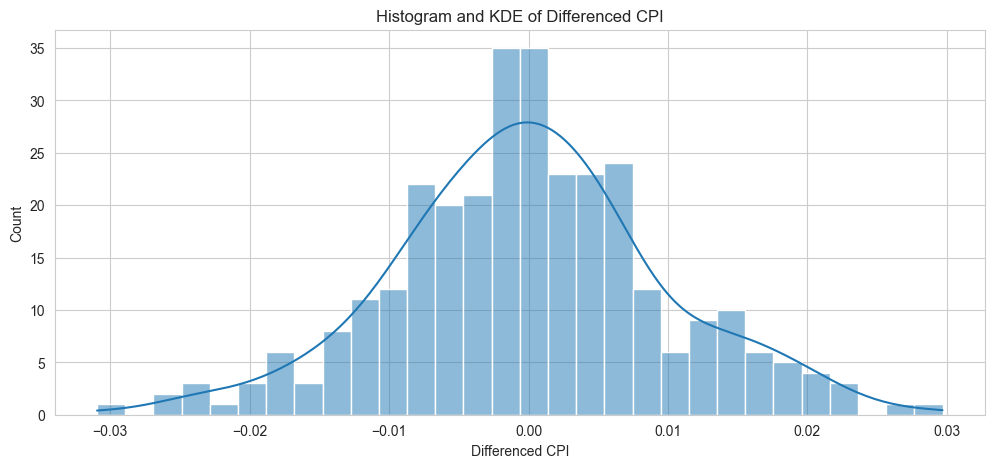

In [209]:

plt.figure(figsize=(12, 5))
sns.histplot(cpi_series, kde=True, bins=30)
plt.title('Histogram and KDE of Differenced CPI')
plt.xlabel('Differenced CPI')
plt.grid(True)
plt.show()
#
# plt.figure(figsize=(12, 5))
# sns.histplot(hicp_series, kde=True, bins=30)
# plt.title('Histogram and KDE of Differenced HICP')
# plt.xlabel('HICP')
# plt.grid(True)
# plt.show()


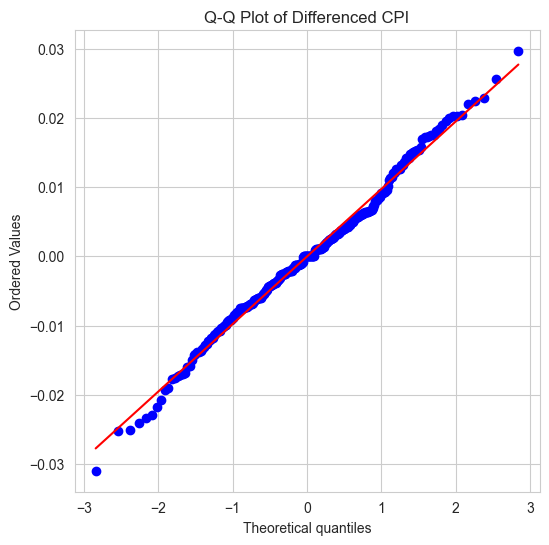

In [210]:

plt.figure(figsize=(6, 6))
stats.probplot(cpi_series, dist="norm", plot=plt)
plt.title("Q-Q Plot of Differenced CPI")
plt.grid(True)
plt.show()

# plt.figure(figsize=(6, 6))
# stats.probplot(hicp_series, dist="norm", plot=plt)
# plt.title("Q-Q Plot of HICP")
# plt.grid(True)
# plt.show()


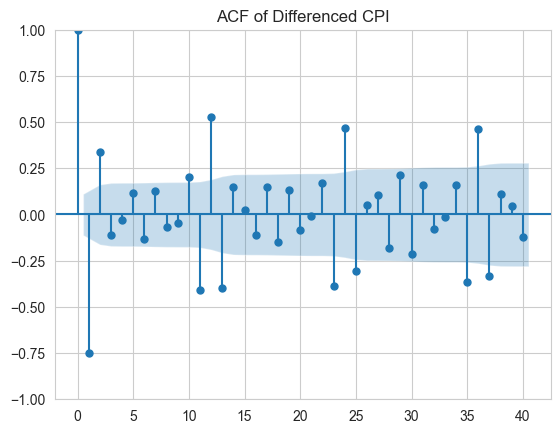

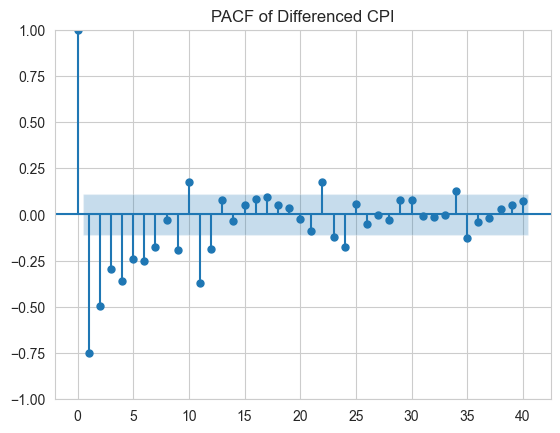

In [211]:

plot_acf(cpi_series, lags=40)
plt.title("ACF of Differenced CPI")
plt.show()

plot_pacf(cpi_series, lags=40, method='ywm')
plt.title("PACF of Differenced CPI")
plt.show()
#
# plot_acf(hicp_series, lags=40)
# plt.title("ACF of Differenced HICP")
# plt.show()
#
# plot_pacf(hicp_series, lags=40, method='ywm')
# plt.title("PACF of Differenced HICP")
# plt.show()


# VAE DATA GENERATION

In [212]:

# This VAE class is the modern way to implement custom models and losses
class VAE(keras.Model):
    def __init__(self, original_dim, intermediate_dim, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim

        # Define Encoder
        encoder_inputs = Input(shape=(original_dim,))
        h = Dense(intermediate_dim, activation="relu")(encoder_inputs)
        z_mean = Dense(latent_dim, name="z_mean")(h)
        z_log_var = Dense(latent_dim, name="z_log_var")(h)

        def sampling(args):
            z_mean, z_log_var = args
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        z = Lambda(sampling, name='z')([z_mean, z_log_var])
        self.encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

        # Define Decoder
        latent_inputs = Input(shape=(latent_dim,))
        h_decoded = Dense(intermediate_dim, activation="relu")(latent_inputs)
        outputs = Dense(original_dim, activation="linear")(h_decoded)
        self.decoder = Model(latent_inputs, outputs, name="decoder")

        # Define trackers for our custom losses
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        # Lists the metrics to be tracked
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        # This method defines the logic for one training step
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # 1. Get latent vectors from the encoder
            z_mean, z_log_var, z = self.encoder(data)
            # 2. Reconstruct the input from the latent vector
            reconstruction = self.decoder(z)

            # 3. Calculate the losses
            squared_difference = tf.square(data - reconstruction)
            # The rest of the logic remains the same.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(squared_difference, axis=-1)
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        # 4. Calculate gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # 5. Update the loss trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

def prepare_vae_data(data, target_column, latent_dim=5, intermediate_dim=32, epochs=100, batch_size=32, verbose=0):
    # Separate features and target
    df = data.copy()
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Normalize
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    original_dim = X_scaled.shape[1]

    # 1. Instantiate the custom VAE model
    vae = VAE(original_dim=original_dim, intermediate_dim=intermediate_dim, latent_dim=latent_dim)

    # 2. Compile the model with only an optimizer. Loss is handled inside.
    # vae.compile(optimizer=keras.optimizers.Adam())
    vae.compile(optimizer=keras.optimizers.Adam(), loss='mse')

    # 3. Train the model
    # vae.fit(X_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=verbose)
    # vae.fit(X_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_scaled,), verbose=verbose)
    vae.fit(X_scaled, X_scaled, epochs=epochs, batch_size=batch_size, validation_data=(X_scaled, X_scaled), verbose=verbose)

    # 4. Use the trained encoder to get the latent representations
    _, _, z_encoded = vae.encoder.predict(X_scaled)

    # 5. Create the final DataFrame
    z_encoded_df = pd.DataFrame(z_encoded, columns=[f"z{i + 1}" for i in range(latent_dim)], index=data.index)
    z_encoded_df[target_column] = y.values

    return z_encoded_df

# Creating Full Series

In [213]:
r_State_Dir = "RState/"
all_series_HICP_target_dir = "AllSamplesHICPtarget/"
all_Series_CPI_target_dir = "AllSamplesCPItarget/"
targetCpi = "CPI"
# targetHICP = "HICP"


In [214]:
# all_columns_ex_hicp = all_columns.copy()
# all_columns_ex_hicp.remove("HICP")
# print(all_columns_ex_hicp)

all_columns_ex_cpi = all_columns.copy()
all_columns_ex_cpi.remove("CPI")
print(all_columns_ex_cpi)

{'RETAILMV', 'RETAILGSR', 'DAX', 'LTIR', 'UR', 'WPI', 'GOODFBT', 'IPI', 'UNERWG', 'ECBDFR', 'EW', 'MMR', 'ECBMLFR', 'STOXX50E', 'EPI', 'RETAILXMV', 'ECBIRRO', 'PPIIP', 'HICP', 'AGRPROD', 'RETAILGF'}


# CPI target series

In [232]:
df_lddd_cpi_target = df_lddd.copy()
df_xCpi = pd.DataFrame(scale(df_lddd_cpi_target), index=df_lddd_cpi_target.index, columns=df_lddd_cpi_target.columns)

df_xCpi["CPI_t+1"] = df_xCpi[targetCpi].shift(-1)   # Shifting CPI to align target at t+1 with features at time t
df_xCpi = df_xCpi.dropna()  # Removes all rows with any null values

In [233]:
df_vae_CPItarget = prepare_vae_data(df_xCpi, targetCpi).dropna()         # Dimensionality reduction via VAE

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [234]:
df_vae_exCPItarget = df_vae_CPItarget.drop(columns=[targetCpi])
combined_df_cpi_target = pd.concat([df_xCpi, df_vae_exCPItarget], axis=1)

LAGS from PACF / ACF
adding lags as guided by PACF / ACF

In [235]:
combined_df_cpi_target_acf = combined_df_cpi_target
pacf_lags = list(range(1, 13))  # lags 1 to 12 from PACF
acf_extra_lags = [23, 24, 25, 35, 36, 37] # ACF
all_cpi_lags = sorted(set(pacf_lags + acf_extra_lags))

for lag in all_cpi_lags:
    combined_df_cpi_target_acf[f'CPI_L{lag}'] = combined_df_cpi_target_acf['CPI'].shift(lag)  # Replace with your actual target column name


LAGS OF FEATURES
up to 3 lags

In [238]:
final_combined_df = combined_df_cpi_target_acf.copy().dropna()

In [239]:
final_combined_df[["CPI_t+1", "CPI", "CPI_L1"]]

,CPI_t+1,CPI,CPI_L1
DATE,,,
2002-05-01,-0.393602,0.660868,-0.260628
2002-06-01,0.265168,-0.393602,0.660868
2002-07-01,-0.393097,0.265168,-0.393602
2002-08-01,0.396619,-0.393097,0.265168
2002-09-01,-0.261646,0.396619,-0.393097
...,...,...,...
2024-08-01,0.518228,-0.686861,0.259994
2024-09-01,0.345068,0.518228,-0.686861
2024-10-01,-1.114238,0.345068,0.518228


In [258]:
# df_lddd_hicp_target = df_lddd.copy()
# df_xHICP = pd.DataFrame(scale(df_lddd_hicp_target), index=df_lddd_hicp_target.index, columns=df_lddd_hicp_target.columns)
# df_xHICP["HICP"] = df_xHICP[targetHICP].shift(-1).dropna()     # Shifting HICP to align target at t+1 with features at time t


In [208]:
# df_vae_HICPtarget = prepare_vae_data(df_xHICP, targetHICP).dropna()         # Dimensionality reduction via VAE


In [260]:
# df_vae_exHICPtarget = df_vae_HICPtarget.drop(columns=[targetHICP])
# combined_df_hicp_target = pd.concat([df_xHICP, df_vae_exHICPtarget], axis=1)


LAGS TARGET from PACF / ACF
adding lags as guided by PACF / ACF

In [261]:
# combined_df_hicp_target_acf = combined_df_hicp_target
# pacf_lags_Hicp = list(range(1, 13))
#
# for lag in pacf_lags_Hicp:
#     combined_df_hicp_target_acf[f'HICP_L{lag}'] = combined_df_hicp_target_acf['HICP'].shift(lag)  # Replace with your actual target column name

LAG FEATURES
up to 3 lags

In [262]:
# final_combined_df_hicp_target = create_lag_features(combined_df_hicp_target_acf, all_columns_ex_hicp, 3).dropna()


In [265]:

filepath_final_combined_target_cpi = os.path.join(t_Data_Dir, "full_cpi_target_data_norm.csv")
final_combined_df.to_csv(filepath_final_combined_target_cpi, index=True) # Keep index (Date) for unscaled

# filepath_final_combined_target_hicp = os.path.join(t_Data_Dir, "full_hicp_target_data_norm.csv")
# final_combined_df_hicp_target.to_csv(filepath_final_combined_target_hicp, index=True) # Keep index (Date) for unscaled


# Creating 100 Sliding Window Subsamples

CPI

In [240]:

# Define the number of rolling splits you want to create
# -----------------------------
# CONFIGURATION
# -----------------------------
num_splits = 100
total_len = len(final_combined_df) # Use the length of the original data
sample_size = total_len - num_splits
print(sample_size)


172


In [279]:

for i in range(num_splits):
    start_idx = i
    end_idx = sample_size + start_idx
    series_name = "dfCPI_full_dataset_subsample"

    if end_idx > total_len:
        print(f"[{series_name}] Reached end of data at split {i + 1}")
        break
    # Split the normalized data
    sub_sample = final_combined_df.iloc[start_idx:end_idx]
    
    # Date-based logging
    start_date = final_combined_df.index[start_idx].strftime('%Y-%m-%d')
    end_date = final_combined_df.index[end_idx - 1].strftime('%Y-%m-%d')

    # Combine and save
    # combined_df = pd.concat([train_df_norm, test_df_norm])
    filename_norm = f"{series_name}_{i + 1}.csv"
    filepath_norm = os.path.join(all_Series_CPI_target_dir, filename_norm)

    sub_sample.to_csv(filepath_norm, index=True)
    print(f"Saved: {filename_norm} | Series: {start_date}---{end_date}")


Saved: dfCPI_full_dataset_subsample_1.csv | Series: 2002-05-01---2016-08-01
Saved: dfCPI_full_dataset_subsample_2.csv | Series: 2002-06-01---2016-09-01
Saved: dfCPI_full_dataset_subsample_3.csv | Series: 2002-07-01---2016-10-01
Saved: dfCPI_full_dataset_subsample_4.csv | Series: 2002-08-01---2016-11-01
Saved: dfCPI_full_dataset_subsample_5.csv | Series: 2002-09-01---2016-12-01
Saved: dfCPI_full_dataset_subsample_6.csv | Series: 2002-10-01---2017-01-01
Saved: dfCPI_full_dataset_subsample_7.csv | Series: 2002-11-01---2017-02-01
Saved: dfCPI_full_dataset_subsample_8.csv | Series: 2002-12-01---2017-03-01
Saved: dfCPI_full_dataset_subsample_9.csv | Series: 2003-01-01---2017-04-01
Saved: dfCPI_full_dataset_subsample_10.csv | Series: 2003-02-01---2017-05-01
Saved: dfCPI_full_dataset_subsample_11.csv | Series: 2003-03-01---2017-06-01
Saved: dfCPI_full_dataset_subsample_12.csv | Series: 2003-04-01---2017-07-01
Saved: dfCPI_full_dataset_subsample_13.csv | Series: 2003-05-01---2017-08-01
Saved: d

HICP

In [280]:

# Define the number of rolling splits you want to create
# -----------------------------
# CONFIGURATION
# -----------------------------
# num_splits = 100
# total_len = len(final_combined_df_hicp_target) # Use the length of the original data
# sample_size = total_len - num_splits
#
# print(sample_size)

197


In [281]:

# for i in range(num_splits):
#     start_idx = i
#     end_idx = sample_size + start_idx
#     series_name = "dfHICP_full_dataset_subsample"
#
#     if end_idx > total_len:
#         print(f"[{series_name}] Reached end of data at split {i + 1}")
#         break
#
#     # Split the normalized data
#     sub_sample = final_combined_df_hicp_target.iloc[start_idx:end_idx]
#
#     # Date-based logging
#     start_date = final_combined_df_hicp_target.index[start_idx].strftime('%Y-%m-%d')
#     end_date = final_combined_df_hicp_target.index[end_idx - 1].strftime('%Y-%m-%d')
#
#     # Combine and save
#     filename_norm = f"{series_name}_{i + 1}.csv"
#     filepath_norm = os.path.join(all_series_HICP_target_dir, filename_norm)
#
#     sub_sample.to_csv(filepath_norm, index=True)
#     print(f"Saved: {filename_norm} | Series: {start_date}---{end_date}")




Saved: dfHICP_full_dataset_subsample_1.csv | Series: 2000-04-01---2016-08-01
Saved: dfHICP_full_dataset_subsample_2.csv | Series: 2000-05-01---2016-09-01
Saved: dfHICP_full_dataset_subsample_3.csv | Series: 2000-06-01---2016-10-01
Saved: dfHICP_full_dataset_subsample_4.csv | Series: 2000-07-01---2016-11-01
Saved: dfHICP_full_dataset_subsample_5.csv | Series: 2000-08-01---2016-12-01
Saved: dfHICP_full_dataset_subsample_6.csv | Series: 2000-09-01---2017-01-01
Saved: dfHICP_full_dataset_subsample_7.csv | Series: 2000-10-01---2017-02-01
Saved: dfHICP_full_dataset_subsample_8.csv | Series: 2000-11-01---2017-03-01
Saved: dfHICP_full_dataset_subsample_9.csv | Series: 2000-12-01---2017-04-01
Saved: dfHICP_full_dataset_subsample_10.csv | Series: 2001-01-01---2017-05-01
Saved: dfHICP_full_dataset_subsample_11.csv | Series: 2001-02-01---2017-06-01
Saved: dfHICP_full_dataset_subsample_12.csv | Series: 2001-03-01---2017-07-01
Saved: dfHICP_full_dataset_subsample_13.csv | Series: 2001-04-01---2017-0

# THE END